In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
from torch.optim import lr_scheduler
import torch.utils.data

In [2]:
images = np.load('object_images.npy')

In [3]:
voxels = np.load('object_voxels_filtered_0.npy')

In [4]:
#Utils
def display3DObject(test_object):   
    print("Displaying the object")
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.voxels(test_object, edgecolor='k')
    plt.show()

In [5]:
train_images = images[1:2000]
val_images = images[2000:2010]
train_voxels = voxels[1:2000]
val_voxels = voxels[2000:2010]

Displaying the object


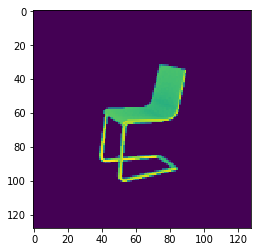

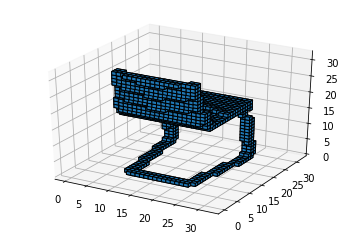

In [6]:
display_id = 56
batch_size = 5
train_data = [train_voxels, train_images]
for _ in range(len(train_data)):
    train_data[_] = torch.from_numpy(train_data[_]).type(torch.FloatTensor)
    train_data[_] = train_data[_].cuda()
train_data = [(train_data[0][i], train_data[1][i]) for i in range(len(train_data[0]))] 
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True, drop_last=True)
plt.imshow(train_images[display_id][0])
display3DObject(train_voxels[display_id])

In [7]:
class cnn1(nn.Module):
    def __init__(self, input_nc=1, ndf=10):
        super(cnn1, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(input_nc, ndf, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(ndf),
            torch.nn.ReLU()
        )
        
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf, ndf*2, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(ndf*2),
            torch.nn.ReLU()
        )
        
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*2, ndf*4, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(ndf*4),
           torch.nn.ReLU()
        )
        
        self.reduce_dim_1 = torch.nn.Conv2d(ndf*4, 1,  kernel_size=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.reduce_dim_1(out)
        return out

In [8]:
class VAE(nn.Module):
    def __init__(self, input_nc=1, z_size=200, ndf=25, cube_size=32):
        super(VAE, self).__init__()
        self.encoderLayer1 = torch.nn.Sequential(
            torch.nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf),
            torch.nn.ReLU()
        )
        
        self.encoderLayer2 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*2),
            torch.nn.ReLU()
        )
        
        self.encoderLayer3 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*4),
            torch.nn.ReLU()
        )
        
        self.encoderLayer4 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*8),
            torch.nn.ReLU()
        )
        
        self.encoderLayer5 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*8, ndf*8, kernel_size=4, stride=4, padding=1),
            torch.nn.BatchNorm2d(ndf*8),
            torch.nn.ReLU()
        )
        
        self.encoderLayer6 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*8, ndf*8, kernel_size=4, stride=2, padding=1),
            torch.nn.Tanh()
        )
        
        self.z_size = z_size
        self.cube_size = cube_size
        
        self.fc1 = nn.Linear(ndf*8, self.z_size)
        self.fc2 = nn.Linear(ndf*8, self.z_size)
        
        self.decoderLayer1 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.z_size, self.cube_size*4, kernel_size=4, stride=2, padding=(0,0,0)),
            torch.nn.BatchNorm3d(self.cube_size*4),
            torch.nn.ReLU()
        )
        
        self.decoderLayer2 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size*4, self.cube_size*2, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_size*2),
            torch.nn.ReLU()
        )
        self.decoderLayer3 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size*2, self.cube_size*1, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_size*1),
            torch.nn.ReLU()
        )

        self.decoderLayer4 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size, 1, kernel_size=4, stride=2,  padding=(1, 1, 1)),
            torch.nn.Sigmoid()
        )
        
    def encoder(self, x): 
        out = self.encoderLayer1(x)
        out = self.encoderLayer2(out)
        out = self.encoderLayer3(out)
        out = self.encoderLayer4(out)
        out = self.encoderLayer5(out)
        out = self.encoderLayer6(out).view(-1, self.z_size)
        return self.fc1(out), self.fc2(out)
    
    #source: https://github.com/bhpfelix/Variational-Autoencoder-PyTorch/blob/master/src/vanila_vae.py
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.cuda.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decoder(self, x):
        out = self.decoderLayer1(x)
        out = self.decoderLayer2(out)
        out = self.decoderLayer3(out)
        out = self.decoderLayer4(out)
        return out
    
    def forward(self, x):
        mu, sigma = self.encoder(x)
        latent = self.reparametrize(mu,sigma)
        latent = latent.view(-1,self.z_size,1,1,1)#latent.unsqueeze(2).unsqueeze(2).unsqueeze(2)
        
        object_3D = self.decoder(latent)
        return object_3D, mu, sigma
        

In [9]:
class mvcnn(nn.Module):
    def __init__(self):
        super(mvcnn, self).__init__()
        self.view_pooling = torch.nn.Conv1d(12, 1,  kernel_size=1)
        self.cnn1 = cnn1()
        self.vae = VAE()
        
    def forward(self, x, number_of_views=12):
        # so x will be of the form [batch, number_of_views, c, h, w]
        x_views = torch.split(x, 1, dim=1)
        output_x = []
        for i in range(number_of_views):
            
            output = self.cnn1(x_views[i]).unsqueeze(dim=-1)
            output_x.append(output)
            
        #output is a list of len=number_of_views and shape [batch, c, h, w, 1] 
        output_x = torch.cat(output_x, dim=-1)
        #output is a list of len=number_of_views and shape [batch, c, h, w, number_of_views]
        #print(output_x.shape)
        n, c, w, h, v = output_x.size()
        output_x = output_x.view(n*c,w*h,v)
        m = nn.MaxPool1d(number_of_views, stride=1)
        pooled =  m(output_x)
        _, _, v = pooled.size()
        output_x = pooled.view(n, c, w, h)
        #print(output_x.shape)
        object_3d, mu, logvar = self.vae(output_x)
        #vae Part
        
        return object_3d, mu, logvar
        #output_x = self.view_pooling(output_x)
        #return output_x
        #Shape must be [batch, 1, 128, 128]
        
        

In [10]:
mvcn = mvcnn().cuda()
lr_vae = 0.0003
lr_d = 0.001
adam_beta_vae = (0.5, 0.5)
adam_beta_d = (0.5, 0.5)
mvvae_solver = optim.Adam(mvcn.parameters(), lr=lr_vae, betas = adam_beta_vae)

In [11]:
# for parameter in mvcn.parameters():
#     print(parameter)

In [ ]:
#Training the mvcnn arch 
num_epochs = 500
val_images = torch.FloatTensor(val_images)
val_voxels = torch.FloatTensor(val_voxels)
loss = nn.BCELoss(size_average=False)
for epoch in range(num_epochs):
    mvvae_losses = []
    klds = []
    for batch_idx, (data3d, data2d) in enumerate(train_loader):
        var_3D_data = Variable(data3d).cuda().float()
        var_2D_data = Variable(data2d).cuda().float()
        generated_object, mu, logvar = mvcn(var_2D_data)
        generated_object= generated_object.squeeze()
            # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
#         KLD_element = mu.pow(2).add_(sigma.exp()).mul_(-1).add_(1).add_(sigma)
#         KLD = torch.sum(KLD_element).mul_(-0.5)
        # https://arxiv.org/abs/1312.6114
        #print(logvar.shape)
        KLD =  -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        #rint(KLD)
        loss_ = loss(generated_object, var_3D_data) + 10*KLD
        mvcn.zero_grad()
        loss_.backward()
        mvvae_solver.step()
        mvvae_losses.append(loss_)
        klds.append(KLD)
    val_3D_data = Variable(val_voxels).cuda().float()
    val_2D_data = Variable(val_images).cuda().float()
    generated_object_val, mu, sigma = mvcn(val_2D_data)
    generated_object_val = torch.round(generated_object_val.squeeze())
    accuracy = np.mean((generated_object_val  == val_3D_data).squeeze().data.cpu().numpy())
    mvvae_losses_mean = np.mean(np.concatenate(mvvae_losses))
    kld_mean =  np.mean(np.concatenate(klds)).data.cpu().numpy()[0]
    print("Epoch: ", epoch, '\n', "Mv VAE loss: ", mvvae_losses_mean.data.cpu().numpy()[0])
    print("Accuracy", accuracy, "KLD loss: ", kld_mean)

Epoch:  0 
 Mv VAE loss:  52359.89
Accuracy 0.6607147216796875 KLD loss:  77.89942
Epoch:  1 
 Mv VAE loss:  39618.98
Accuracy 0.6607147216796875 KLD loss:  115.61494
Epoch:  2 
 Mv VAE loss:  37853.773
Accuracy 0.7614990234375 KLD loss:  121.33208
Epoch:  3 
 Mv VAE loss:  36788.87
Accuracy 0.781439208984375 KLD loss:  133.74643
Epoch:  4 
 Mv VAE loss:  36122.312
Accuracy 0.7874725341796875 KLD loss:  139.84985
Epoch:  5 
 Mv VAE loss:  35281.285
Accuracy 0.7563629150390625 KLD loss:  144.11613
Epoch:  6 
 Mv VAE loss:  34702.164
Accuracy 0.7804534912109375 KLD loss:  147.524
Epoch:  7 
 Mv VAE loss:  34268.766
Accuracy 0.8042205810546875 KLD loss:  153.55865
Epoch:  8 
 Mv VAE loss:  33765.266
Accuracy 0.8177215576171875 KLD loss:  154.05928
Epoch:  9 
 Mv VAE loss:  33369.883
Accuracy 0.83316650390625 KLD loss:  158.9015
Epoch:  10 
 Mv VAE loss:  32947.668
Accuracy 0.8197540283203125 KLD loss:  163.6201
Epoch:  11 
 Mv VAE loss:  32534.914
Accuracy 0.8244659423828125 KLD loss:  16

In [ ]:
# #Testing the mvcnn architecture 

# mvcn = mvcnn().cuda()

# print(images[1:3].shape)
# test_image = Variable(torch.FloatTensor(images[0:10])).cuda()
# mvcn(test_image).shape

In [ ]:
# plt.imshow(images[456][0])
# display3DObject(voxels[456])

In [ ]:
# print(value.shape)
# images = np.load('padded_gray_chair_imgs.npy')

In [ ]:
# images.shape

In [ ]:
# cnn1 = cnn1()

In [ ]:
# value = Variable(torch.FloatTensor(images[1])).view(-1,1,128,128)
# print(value.shape)
# cnn1(value)

In [ ]:
# lis = []
# value = Variable(torch.FloatTensor(images[1:4])).view(-1,1,128,128)
# print(value.shape)
# value1 = cnn1(value)
# lis.append(value1)
# value = Variable(torch.FloatTensor(images[1:4])).view(-1,1,128,128)
# print(value.shape)
# lis.append(cnn1(value))
# torch.cat(lis,1)